In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [45]:
df = pd.read_csv(r'../data/GII_2011_2024_long_format.tsv', sep='\t')
print(df.head())
print(df.info())
df_clean = df[(df['Rank'] != -1) & (df['Score'] != -1)].copy()
print(f"Number of countries: {df_clean['Country'].nunique()}, number of records after cleaning: {len(df_clean)}")

  Country  Year  Rank  Score
0     AGO  2011    -1  -1.00
1     AGO  2012   135  22.20
2     AGO  2013   135  23.46
3     AGO  2014   135  23.82
4     AGO  2015   120  26.20
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2086 entries, 0 to 2085
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Country  2086 non-null   object 
 1   Year     2086 non-null   int64  
 2   Rank     2086 non-null   int64  
 3   Score    2086 non-null   float64
dtypes: float64(1), int64(2), object(1)
memory usage: 65.3+ KB
None
Number of countries: 149, number of records after cleaning: 1862


In [31]:
# ... (code to load and clean the data)
df_cleaned = df.dropna(subset=['Rank', 'Score']).copy()

In [47]:
# ===  Add logical classification (Region, Performance Category) ===
region_mapping = {
    'IRL': 'Europe', 'GBR': 'Europe', 'DEU': 'Europe', 'FRA': 'Europe',
    'USA': 'North America', 'CAN': 'North America', 'MEX': 'North America',
    'CHN': 'Asia', 'JPN': 'Asia', 'KOR': 'Asia', 'SGP': 'Asia',
    'BRA': 'South America', 'ARG': 'South America', 'CHL': 'South America',
    'EGY': 'Africa', 'ZAF': 'Africa', 'KEN': 'Africa', 'NGA': 'Africa'
}
df_clean['Region'] = df_clean['Country'].map(region_mapping).fillna('Other')

df_clean['Performance_Category'] = pd.cut(
    df_clean['Score'], bins=[0, 25, 50, 75, 100], labels=['Low', 'Medium', 'Good', 'Excellent']
)

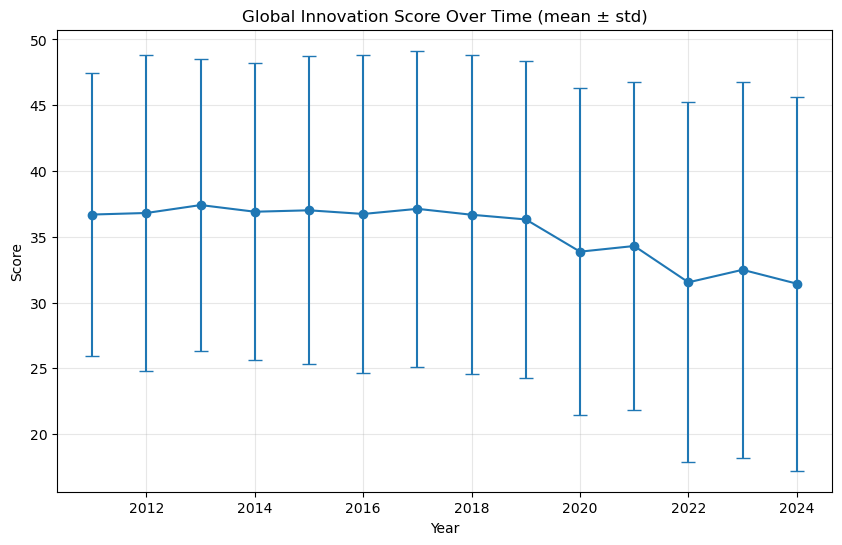

In [49]:
# === Global trend analysis ===
plt.figure(figsize=(10, 6))
yearly_avg = df_clean.groupby('Year')['Score'].agg(['mean', 'std'])
plt.errorbar(yearly_avg.index, yearly_avg['mean'], yerr=yearly_avg['std'], marker='o', capsize=5)
plt.title('Global Innovation Score Over Time (mean ± std)')
plt.xlabel('Year')
plt.ylabel('Score')
plt.grid(alpha=0.3)
plt.show()

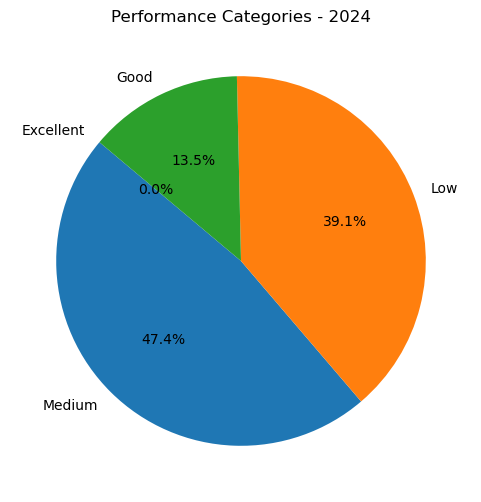

In [77]:
# === Distribution of performance categories in 2024 ===
plt.figure(figsize=(6, 6))
cat_2024 = df_clean[df_clean['Year'] == 2024]['Performance_Category'].value_counts()
plt.pie(cat_2024.values, labels=cat_2024.index, autopct='%1.1f%%', startangle=140)
plt.title('Performance Categories - 2024')
plt.show()

In [69]:
# === 10 Top and bottom countries 2024 ===
top_2024 = df_clean[df_clean['Year'] == 2024].nsmallest(10, 'Rank')
bottom_2024 = df_clean[df_clean['Year'] == 2024].nlargest(10, 'Rank')

print(" Top 10 Countries 2024:\n", top_2024[['Country', 'Rank', 'Score']])
print("\n Bottom 10 Countries 2024:\n", bottom_2024[['Country', 'Rank', 'Score']])

 Top 10 Countries 2024:
      Country  Rank  Score
363      CHE     1   67.5
1791     SWE     2   64.5
1987     USA     3   62.4
377      CHL     4   32.6
1721     SGP     4   61.2
685      GBR     5   61.0
1063     KOR     6   60.9
629      FIN     7   59.4
1455     NLD     8   58.8
503      DEU     9   58.1

 Bottom 10 Countries 2024:
      Country  Rank  Score
13       AGO   133   10.2
1413     NER   132   11.2
1259     MLI   131   11.8
615      ETH   130   12.3
167      BFA   129   12.8
1329     MOZ   128   13.1
125      BDI   127   13.2
1343     MRT   126   13.2
1287     MMR   125   13.8
1441     NIC   124   14.0


In [71]:
# === Volatility analysis ===
volatility = df_clean.groupby('Country').agg({
    'Score': ['std', 'mean'], 'Rank': ['std', 'mean'], 'Year': 'count'})

volatility.columns = ['Score_Std', 'Score_Mean', 'Rank_Std', 'Rank_Mean', 'Years_Count']
volatility = volatility[volatility['Years_Count'] >= 5]
volatility = volatility.sort_values('Score_Std', ascending=False)

print("\n Most volatile countries (Score):\n", volatility.head())


 Most volatile countries (Score):
          Score_Std  Score_Mean   Rank_Std   Rank_Mean  Years_Count
Country                                                           
AGO       6.484687   18.135000   5.221863  131.125000            8
MOZ       5.976184   22.446923  13.022170  113.923077           13
MLI       5.623512   21.949286   8.562954  117.357143           14
UGA       5.483335   23.867143  10.875924  108.142857           14
GTM       5.450769   24.943571  10.807252  102.214286           14


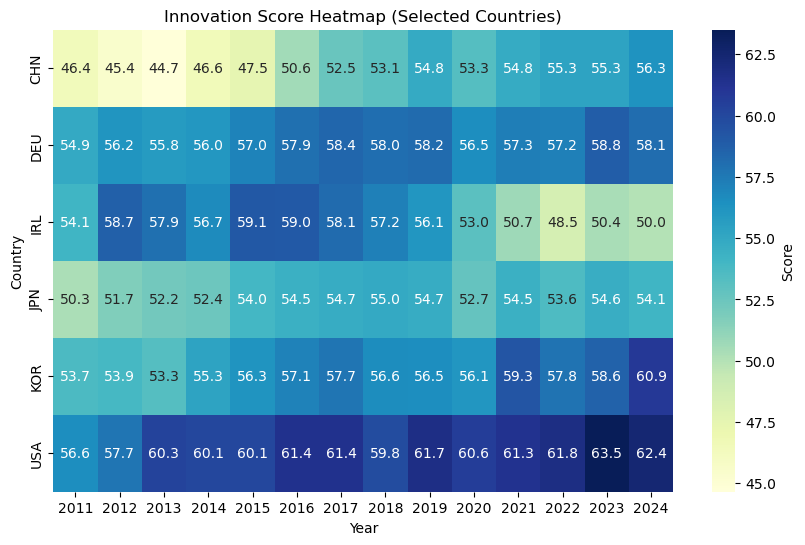

In [83]:
# === Heatmap of selected countries ===
pivot = df_clean[df_clean['Country'].isin(['USA', 'CHN', 'DEU', 'IRL', 'JPN', 'KOR'])].pivot(
    index='Country', columns='Year', values='Score'
)
plt.figure(figsize=(10, 6))
sns.heatmap(pivot, annot=True, fmt='.1f', cmap='YlGnBu', cbar_kws={'label': 'Score'})
plt.title('Innovation Score Heatmap (Selected Countries)')
plt.show()

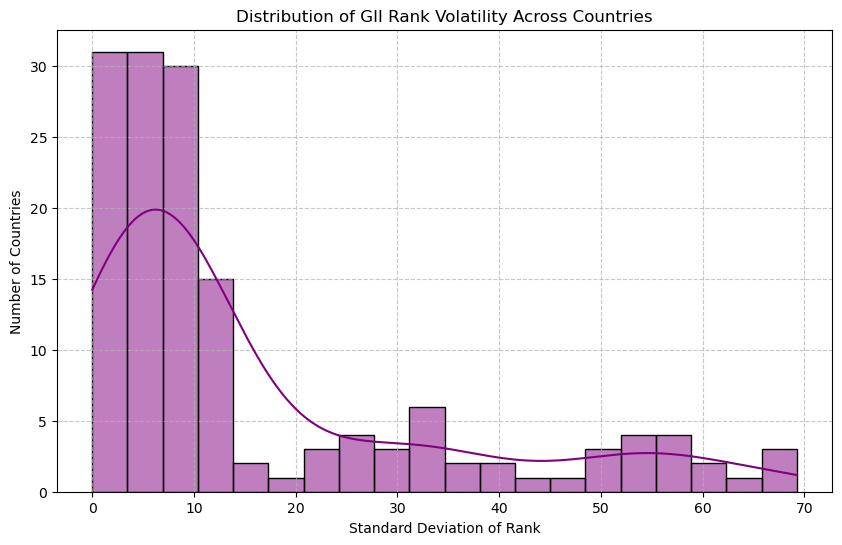

In [37]:
# Visualize distribution of rank volatility
plt.figure(figsize=(10, 6))
sns.histplot(rank_stability, bins=20, kde=True, color='purple')
plt.title('Distribution of GII Rank Volatility Across Countries')
plt.xlabel('Standard Deviation of Rank')
plt.ylabel('Number of Countries')
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

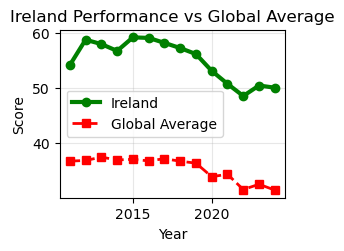

In [55]:
# Plot 4: Ireland vs Global Average comparison
plt.subplot(2, 2, 4)
ireland_data = df_clean[df_clean['Country'] == 'IRL']
global_avg = df_clean.groupby('Year')['Score'].mean()

plt.plot(ireland_data['Year'], ireland_data['Score'], 
         marker='o', linewidth=3, label='Ireland', color='green')
plt.plot(global_avg.index, global_avg.values, 
         marker='s', linewidth=2, label='Global Average', 
         color='red', linestyle='--')
plt.title('Ireland Performance vs Global Average')
plt.xlabel('Year')
plt.ylabel('Score')
plt.legend()
plt.grid(True, alpha=0.3)

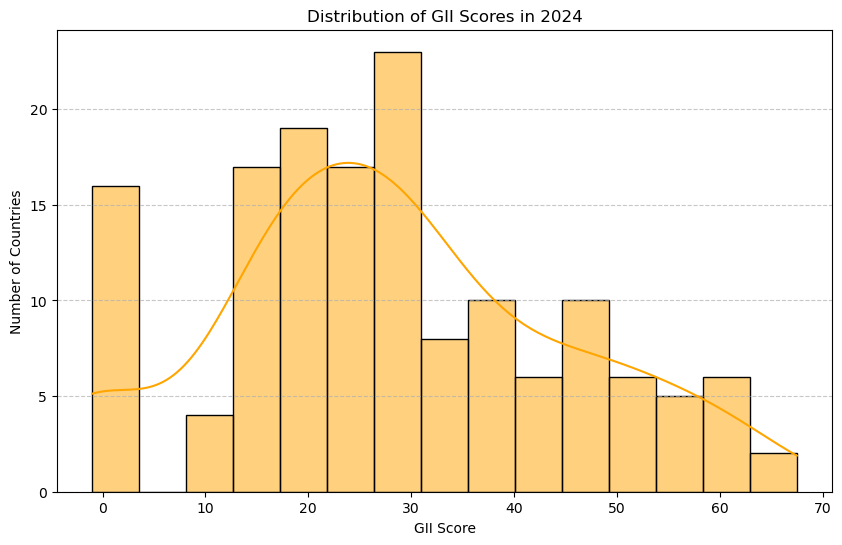

In [33]:
# Distribution of Scores for a recent year (e.g., 2024)
year_to_examine = 2024
df_year = df_cleaned[df_cleaned['Year'] == year_to_examine]['Score'].dropna()

if not df_year.empty:
    plt.figure(figsize=(10, 6))
    sns.histplot(df_year, kde=True, bins=15, color='orange')
    plt.title(f'Distribution of GII Scores in {year_to_examine}')
    plt.xlabel('GII Score')
    plt.ylabel('Number of Countries')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()
else:
    print(f"No valid score data for year {year_to_examine}.")